In [3]:
!pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0%2Bcpu-cp311-cp311-linux_x86_64.whl.metadata (26 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0%2Bcpu-cp311-cp311-linux_x86_64.whl (178.7 MB)
Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl (11 kB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

data = np.genfromtxt('dataset/weather_data_random_train_new.csv', delimiter=',', skip_header=1)

In [6]:
X, y = data[:, :-1], data[:, -1]
np.shape(X), np.shape(y)

((960, 22), (960,))

In [7]:
# 커스텀 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 회귀 모델 정의
class RegressionModel(nn.Module):
    def __init__(self, input_dim=22):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=1000):
    model.train()
    epoch_bar = tqdm(range(num_epochs), desc="Epochs")
    losses = []  
    for epoch in epoch_bar:
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.reshape(-1, 1))
            losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        epoch_bar.set_postfix({"Avg Loss": f"{avg_loss:.4f}"})
    return losses

In [8]:
dataset = CustomDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


model = RegressionModel(input_dim=22)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
losses = train_model(model, train_loader, criterion, optimizer)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

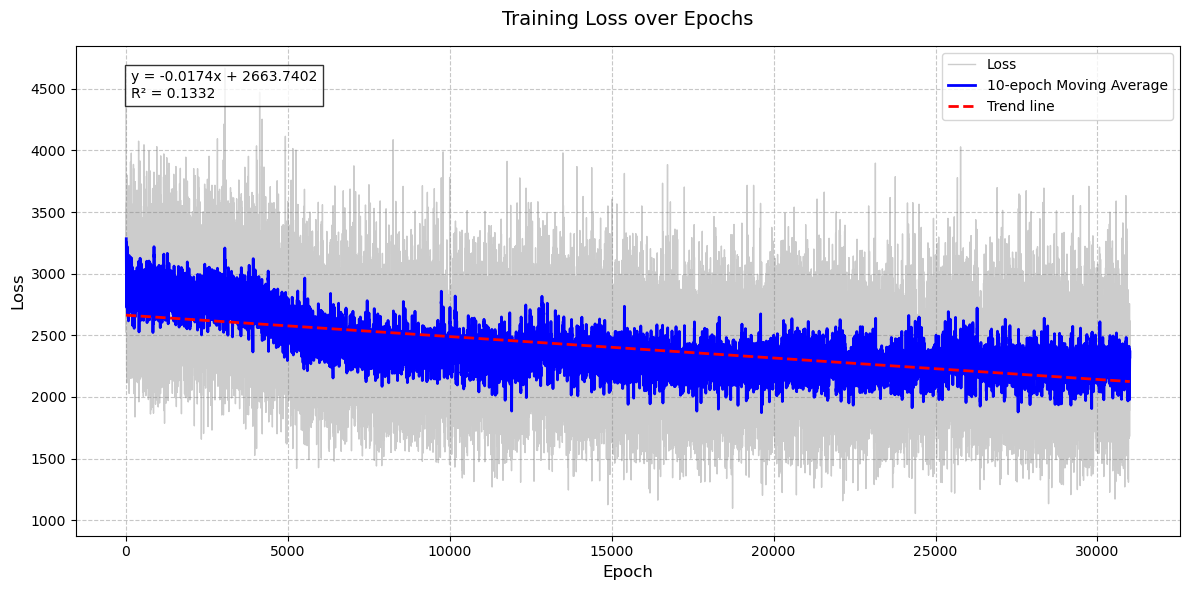

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

detached_losses = [torch.Tensor.detach(loss).cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in losses]

sns.set_palette("husl")

x = np.arange(len(detached_losses))
y = np.array(detached_losses)

# 선형 회귀
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept


window_size = 10
moving_avg = pd.Series(detached_losses).rolling(window=window_size).mean()


plt.figure(figsize=(12, 6))

plt.plot(x, y, label='Loss', alpha=0.4, linewidth=1, color='gray')
plt.plot(moving_avg, color='blue', label=f'{window_size}-epoch Moving Average', 
         linewidth=2)
plt.plot(x, line, color='red', label='Trend line', 
         linestyle='--', linewidth=2)

plt.title('Training Loss over Epochs', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 격자 추가
plt.grid(True, linestyle='--', alpha=0.7)

# 범례
plt.legend(fontsize=10)

# 추세선 방정식과 R-squared 값 표시
equation = f'y = {slope:.4f}x + {intercept:.4f}'
r_squared = f'R² = {r_value**2:.4f}'
plt.text(0.05, 0.95, equation + '\n' + r_squared, 
         transform=plt.gca().transAxes,
         verticalalignment='top', 
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8))

# 여백 조정
plt.tight_layout()

plt.show()

    